### Von Frey XO sequence converter


In [602]:
library(readr)
library(ggplot2)
library(ggpubr)
library(ggiraphExtra)
library(dplyr)
library(tidyverse)
library(rstatix)
library(DescTools)
library(readxl)
library(writexl)
library(lubridate)
library(emmeans)
library(ggpubr)

### Define some custom functions

In [603]:
`%notin%` <- Negate(`%in%`)

acPage = function(w1=12, h1=6, r1=1, c1=1, m1=2, m2=2, m3=2, m4=2){
  options(repr.plot.width=w1, repr.plot.height= h1) 
  par(mfrow=c(r1,c1), mar=c(m1,m2,m3,m4))
}

## Provide file name of the excel file that includes **data** and **meta** tabs
### The **data** tab stores observation and last filament results
### The **meta** tab establishes comparison pairs

In [604]:
data_file <- "GE29_Rats_COV.xlsx"  # excel data table should be placed in the main folder

### Set on-screen plotting parameters

In [605]:
acPage()

### Set up additional parameters

In [606]:
paw <- 'LEFT' #'RIGHT',  # define paw to use
sex <- "female"  # define sex of animals if needed. Assign "" is sex is not defined
species <- "rats" # define species of animal RATS or MICE
res_file <- paste('result', data_file, sep='.')  # result file
post_hoc_method <- "bonferroni"

In [607]:
# Folder definitions
main_folder = ""
data_folder <- "files"
par_folder <- "parameters"

sex <- toupper(sex)

if (species == "rats"){
    pain_threshold <- 5
    max_res <- 15
}

### Read species specific parameters 
### Perform Von Frey Test calculations

In [608]:
XO_file <- paste(species, "final.previous.filaments.XO.csv", sep='.')
stat_file <- paste(species, "observation-statistics.csv", sep='.')

observation_table <- read.csv(file.path(par_folder, stat_file), row.names=1, stringsAsFactors=FALSE)
XO.table <- read.csv(file.path(par_folder, XO_file), row.names=1, stringsAsFactors=FALSE) #, col_types = "nnn")

VonFrey = function(obs='', last=0){
    obs <- toupper(obs)
    res <- 0
    if (obs == '' | last == 0) { return (-1)} 
    else if (obs == 'OOOOO' & last == 5.18) { res <- max_res } 
    else if (obs == 'XXXX' & last == 3.61) { res <- 0.2 }
    else if (length(which(rownames(XO.table) == last)) == 0 | length(which(rownames(observation_table) == obs))== 0) { return (-1)}
    else {
    a <- substr(obs, nchar(obs)-1, nchar(obs)-1)
    prev <- XO.table[which(rownames(XO.table) == last), a]
    dif <- abs(last - prev)
    p50 <- last + dif * observation_table[which(rownames(observation_table) == obs),'STATISTIC']
    res <- (10**p50)/10000
    if (res > 15) { res <- max_res }
    if (res < 0.2) { res <- 0.20 }
    return(as.numeric(sprintf("%.2f", res)))
    }
}
TruncateObservation = function(obs='', met=2){
    obs <- toupper(obs)
    if (obs == '') { return ("") } 
    if (met == 2) { return (obs) }
    if (met == 1) {  # Jenny's short method
    len <- nchar(obs)  
    Xpos <- StrPos(obs, 'X') 
    if (is.na(Xpos)) { return (obs) }   
    obs1 <- substr(obs, Xpos, len)
 
    return (obs1)
    }
}

## Read DATA and META files from main folder

In [609]:
x <- readxl::read_excel(data_file, sheet = "data") 
meta <- readxl::read_excel(data_file, sheet = "meta")

In [610]:
x <- x %>% rename_with(toupper)
meta <- meta %>% rename_with(toupper)

# convert key parameters to uppercase
x <- x %>% dplyr::mutate (
                DATE = ymd(DATE),
                SEX = toupper(SEX), 
                OBSERVATION = toupper(OBSERVATION),
                PAW = toupper(PAW))
x <- x %>% dplyr::arrange(SEX, TIMEPOINT, ID, PAW)
head(x)
head(meta)

DATE,SPECIES,SEX,GROUP,ID,ANIMAL_ID,CAGE,NOTCH,PAW,TIMEPOINT,OBSERVATION,LAST
<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>
2022-01-13,RAT,FEMALE,SCRs,A,AC225,1,L,LEFT,0,OOOOXXOXO,4.74
2022-01-13,RAT,FEMALE,SCRs,A,AC226,1,R,LEFT,0,OOOOO,5.18
2022-01-13,RAT,FEMALE,SCRs,A,AC227,1,N,LEFT,0,OOOOXOXOX,5.18
2022-01-14,RAT,FEMALE,SCRs,A,AC340,7,L,LEFT,0,OOOOXXOXO,4.74
2022-01-14,RAT,FEMALE,SCRs,A,AC341,7,R,LEFT,0,OOOOXXOXO,4.74
2022-01-14,RAT,FEMALE,SCRs,A,AC342,7,N,LEFT,0,OOOOXOXXO,4.74


COMPARISON,TREATMENT,REFERENCE,SPECIES,SEX
<dbl>,<chr>,<chr>,<chr>,<chr>
1,MBP84_104,PBS,RAT,FEMALE
2,MBP84_104,SCRs,RAT,FEMALE
3,OC_WT,PBS,RAT,FEMALE
4,OC_WT,SCRs,RAT,FEMALE


### filter by specific sex if **sex** is assigned

In [611]:
if (sex != ""){ x <- x %>% filter (SEX == sex) }

### Calculate **Von Frey Test** values

In [612]:
x <- x %>% dplyr::mutate(RESULT = mapply(VonFrey, OBSERVATION, LAST))

In [613]:
head(x, 5)

DATE,SPECIES,SEX,GROUP,ID,ANIMAL_ID,CAGE,NOTCH,PAW,TIMEPOINT,OBSERVATION,LAST,RESULT
<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
2022-01-13,RAT,FEMALE,SCRs,A,AC225,1,L,LEFT,0,OOOOXXOXO,4.74,8.34
2022-01-13,RAT,FEMALE,SCRs,A,AC226,1,R,LEFT,0,OOOOO,5.18,15.00
2022-01-13,RAT,FEMALE,SCRs,A,AC227,1,N,LEFT,0,OOOOXOXOX,5.18,11.66
2022-01-14,RAT,FEMALE,SCRs,A,AC340,7,L,LEFT,0,OOOOXXOXO,4.74,8.34
2022-01-14,RAT,FEMALE,SCRs,A,AC341,7,R,LEFT,0,OOOOXXOXO,4.74,8.34


### Check for errors reported by Von Frey calculator
#### Negative RESULTs (-1) indicate an error most likely related to incorrect XO data entry

In [614]:
x %>% filter(RESULT < 0)

DATE,SPECIES,SEX,GROUP,ID,ANIMAL_ID,CAGE,NOTCH,PAW,TIMEPOINT,OBSERVATION,LAST,RESULT
<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>


### Write results in file with **Results.** prefix

In [615]:
write_xlsx(list(data = x, meta = meta), res_file)

### Prepare dataset for ANOVA analysis and plotting

In [616]:
x <- x %>% filter(RESULT > 0)
lp_x_names <- c('SEX', 'GROUP', 'PAW', 'TIMEPOINT', 'RESULT', 'ANIMAL_ID')
lp_meta_names <- c('COMPARISON', 'TREATMENT', 'REFERENCE')

In [617]:
lp <- x %>% 
    select(all_of(lp_x_names)) %>% 
        mutate(DAY = TIMEPOINT, 
               TIMEPOINT = as.integer(TIMEPOINT),
               DAY = factor(TIMEPOINT),
               GROUP = factor(GROUP),
               ID = row_number()) %>% 
        print

# A tibble: 420 × 8
   SEX    GROUP PAW   TIMEPOINT RESULT ANIMAL_ID DAY      ID
   <chr>  <fct> <chr>     <int>  <dbl> <chr>     <fct> <int>
 1 FEMALE SCRs  LEFT          0   8.34 AC225     0         1
 2 FEMALE SCRs  LEFT          0  15    AC226     0         2
 3 FEMALE SCRs  LEFT          0  11.7  AC227     0         3
 4 FEMALE SCRs  LEFT          0   8.34 AC340     0         4
 5 FEMALE SCRs  LEFT          0   8.34 AC341     0         5
 6 FEMALE SCRs  LEFT          0   9.49 AC342     0         6
 7 FEMALE SCRs  RIGHT         0  13.8  AC225     0         7
 8 FEMALE SCRs  RIGHT         0  15    AC226     0         8
 9 FEMALE SCRs  RIGHT         0  15    AC227     0         9
10 FEMALE SCRs  RIGHT         0  15    AC340     0        10
# … with 410 more rows


In [618]:
print(meta)

# A tibble: 4 × 5
  COMPARISON TREATMENT REFERENCE SPECIES SEX   
       <dbl> <chr>     <chr>     <chr>   <chr> 
1          1 MBP84_104 PBS       RAT     FEMALE
2          2 MBP84_104 SCRs      RAT     FEMALE
3          3 OC_WT     PBS       RAT     FEMALE
4          4 OC_WT     SCRs      RAT     FEMALE


### Set up comparison pairs

In [619]:
meta <- meta %>% mutate(COMPARISON = mapply(sprintf, "%s-%s", TREATMENT, REFERENCE)) %>% print

# A tibble: 4 × 5
  COMPARISON     TREATMENT REFERENCE SPECIES SEX   
  <chr>          <chr>     <chr>     <chr>   <chr> 
1 MBP84_104-PBS  MBP84_104 PBS       RAT     FEMALE
2 MBP84_104-SCRs MBP84_104 SCRs      RAT     FEMALE
3 OC_WT-PBS      OC_WT     PBS       RAT     FEMALE
4 OC_WT-SCRs     OC_WT     SCRs      RAT     FEMALE


### Filter by LEFT or RIGHT paw

In [620]:
#if (paw != "") { lp <- lp %>% filter(PAW == paw) }

In [621]:
min_res <- lp %>% select (RESULT) %>% min %>% print
max_res <- lp %>% select (RESULT) %>% max %>% print

[1] 0.88
[1] 15


## Summary statistics
Compute some summary statistics (count, mean and sd) of the variable weight organized by groups:

# Two-way ANOVA

## Summary statistics
Compute the mean and the SD (standard deviation) of the score by groups:

In [622]:
lp_stat <- lp %>%
  group_by(PAW, GROUP, DAY) %>%
        get_summary_stats(RESULT, type = "mean_sd") %>% print

# A tibble: 70 × 7
   GROUP     PAW   DAY   variable     n  mean    sd
   <fct>     <chr> <fct> <chr>    <dbl> <dbl> <dbl>
 1 COV2      LEFT  0     RESULT       6 13.6   2.55
 2 COV2      LEFT  1     RESULT       6  8.20  4.63
 3 COV2      LEFT  3     RESULT       6  6.35  1.99
 4 COV2      LEFT  5     RESULT       6  7.79  3.27
 5 COV2      LEFT  7     RESULT       6 12.2   1.94
 6 COV2      LEFT  13    RESULT       6  8.00  2.08
 7 COV2      LEFT  18    RESULT       6 11.5   2.92
 8 MBP84_104 LEFT  0     RESULT       6 11.8   3.46
 9 MBP84_104 LEFT  1     RESULT       6  5.08  3.11
10 MBP84_104 LEFT  3     RESULT       6  4.93  3.19
# … with 60 more rows


## Visualization
Create a box plot of the score by gender levels, colored by education levels:

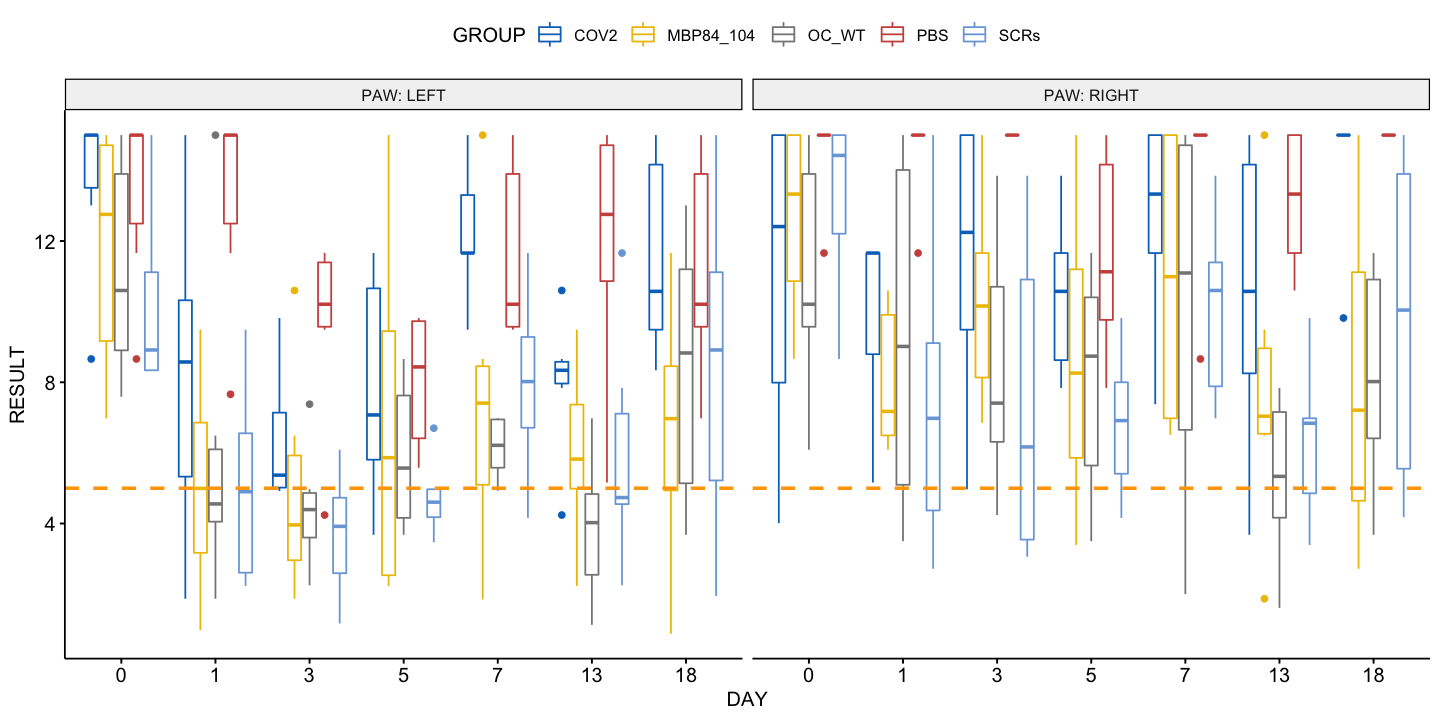

In [623]:

bxp <- lp %>% ggboxplot(
    x = "DAY", y = "RESULT",
    color = "GROUP", 
    palette = "jco") +
    geom_hline(yintercept=5, linetype="dashed", color = "orange", size=1)+
    #faset_wrap(~PAW) +
  facet_wrap( ~ PAW,  labeller = "label_both")

plot(bxp)

In [632]:
lp_outs <- lp %>%
  group_by(PAW, DAY, GROUP) %>%
    identify_outliers(RESULT) %>% 
        filter(is.extreme == TRUE) %>% print()

lp <- lp %>% anti_join(lp_outs, by = "ID") %>% print()

# A tibble: 1 × 10
  GROUP PAW   DAY   SEX   TIMEPOINT RESULT ANIMAL_ID    ID is.outlier is.extreme
  <fct> <chr> <fct> <chr>     <int>  <dbl> <chr>     <int> <lgl>      <lgl>     
1 COV2  LEFT  0     FEMA…         0   13.0 AC350        41 TRUE       TRUE      
# A tibble: 411 × 8
   SEX    GROUP PAW   TIMEPOINT RESULT ANIMAL_ID DAY      ID
   <chr>  <fct> <chr>     <int>  <dbl> <chr>     <fct> <int>
 1 FEMALE SCRs  LEFT          0   8.34 AC225     0         1
 2 FEMALE SCRs  LEFT          0  15    AC226     0         2
 3 FEMALE SCRs  LEFT          0  11.7  AC227     0         3
 4 FEMALE SCRs  LEFT          0   8.34 AC340     0         4
 5 FEMALE SCRs  LEFT          0   8.34 AC341     0         5
 6 FEMALE SCRs  LEFT          0   9.49 AC342     0         6
 7 FEMALE SCRs  RIGHT         0  13.8  AC225     0         7
 8 FEMALE SCRs  RIGHT         0  15    AC226     0         8
 9 FEMALE SCRs  RIGHT         0  15    AC227     0         9
10 FEMALE SCRs  RIGHT         0  15    AC340   

### Build the linear model

In [633]:
model  <- lm(RESULT ~ PAW * GROUP * DAY, data = lp)

### Create a QQ plot of residuals

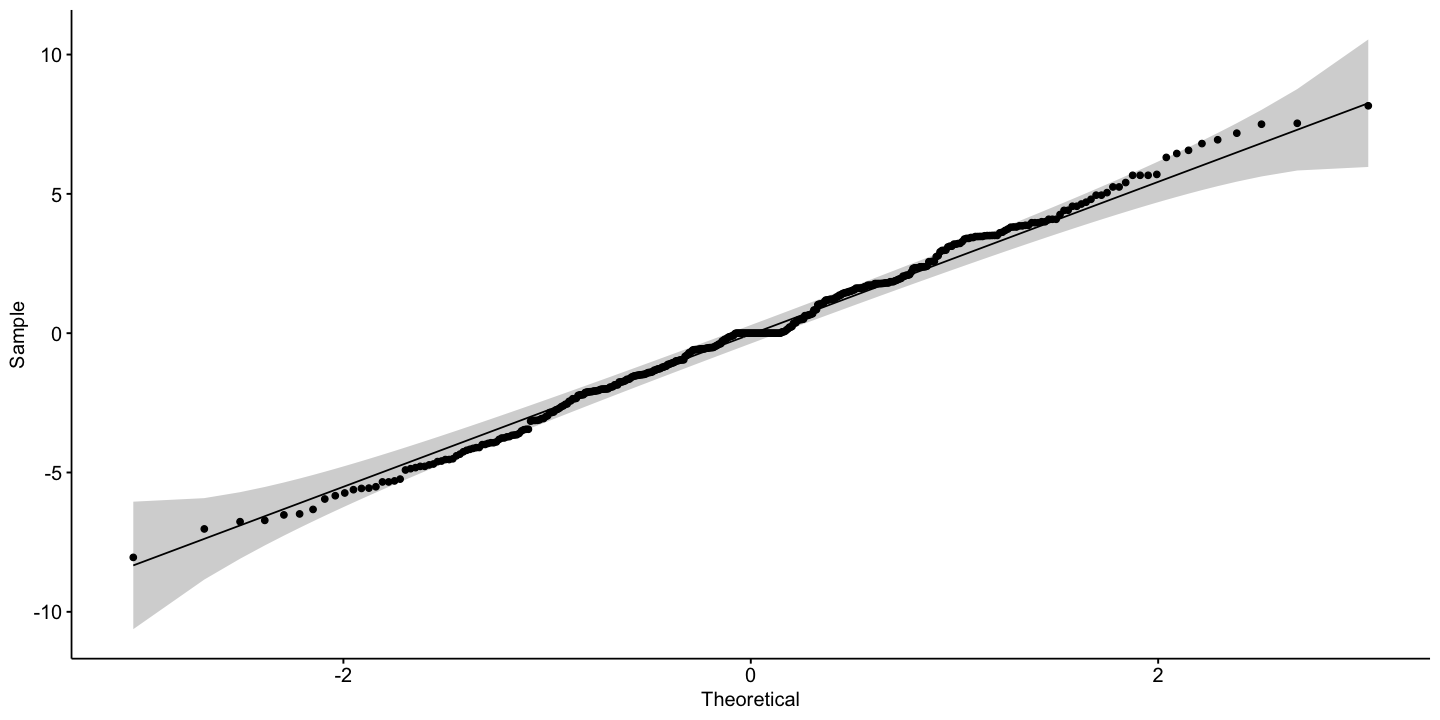

In [634]:
model %>% residuals %>% ggqqplot

### Compute Shapiro-Wilk test of normality

In [635]:
model %>% residuals %>% shapiro_test

variable,statistic,p.value
<chr>,<dbl>,<dbl>
.,0.9958193,0.3472365


In [638]:
#lp %>% group_by(PAW, TIMEPOINT, GROUP) %>% shapiro_test(RESULT) %>% print

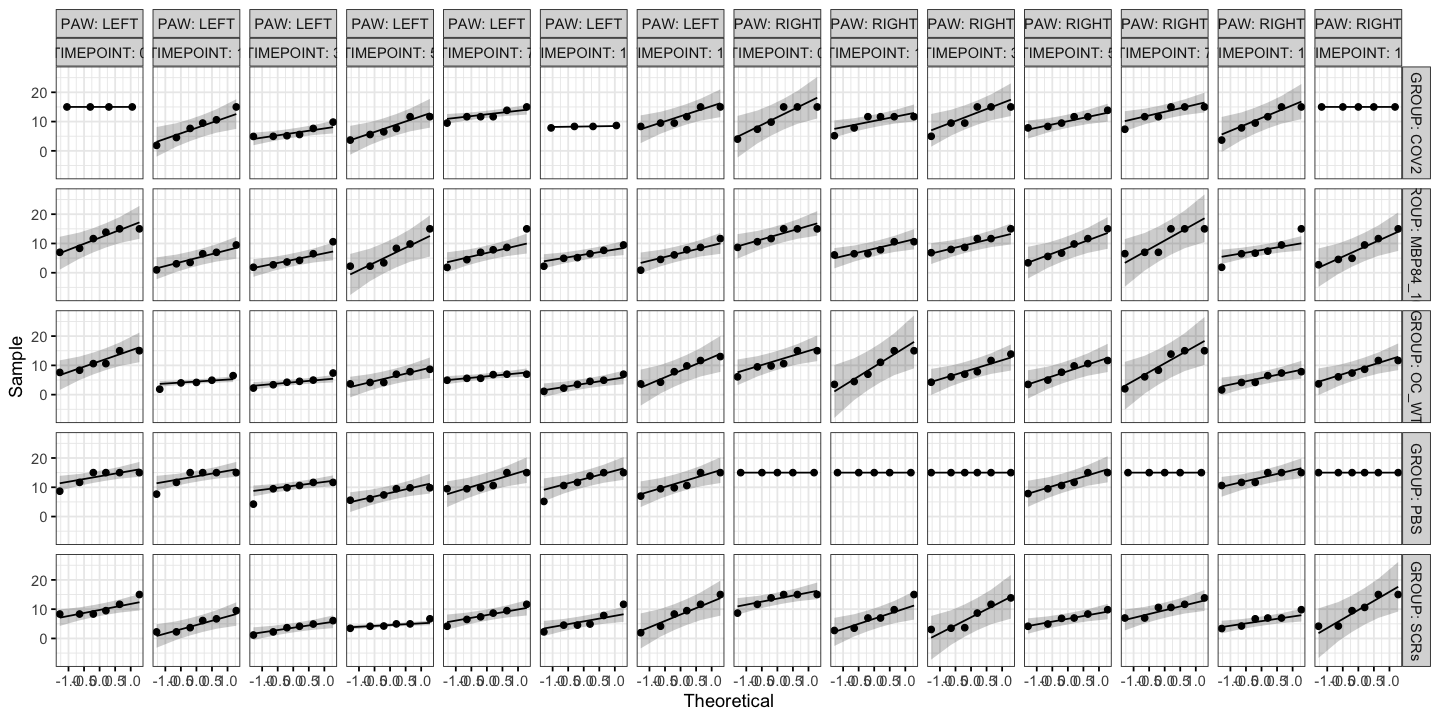

In [640]:
ggqqplot(lp, "RESULT", ggtheme = theme_bw()) +
  facet_grid( GROUP ~ PAW * TIMEPOINT, labeller = "label_both")

In [641]:
lp %>% group_by(PAW, TIMEPOINT) %>% anova_test(RESULT ~ GROUP)

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()



,PAW,TIMEPOINT,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,LEFT,0,GROUP,4,23,2.232,0.097000,,0.280
2,LEFT,1,GROUP,4,24,7.535,0.000442,*,0.557
3,LEFT,3,GROUP,4,25,5.769,0.002000,*,0.480
4,LEFT,5,GROUP,4,25,1.183,0.342000,,0.159
5,LEFT,7,GROUP,4,25,5.572,0.002000,*,0.471
6,LEFT,13,GROUP,4,23,7.091,0.000714,*,0.552
7,LEFT,18,GROUP,4,25,1.815,0.158000,,0.225
8,RIGHT,0,GROUP,4,24,1.504,0.233000,,0.200
9,RIGHT,1,GROUP,4,24,3.847,0.015000,*,0.391


In [642]:
# Group data for anova
lp %>%
  group_by(PAW, TIMEPOINT) %>%
      anova_test(RESULT ~ GROUP, error = model)

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()

Coefficient covariances computed by hccm()



,PAW,TIMEPOINT,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,LEFT,0,GROUP,4,341,1.733,1.42e-01,,0.020
2,LEFT,1,GROUP,4,341,7.809,4.96e-06,*,0.084
3,LEFT,3,GROUP,4,341,3.154,1.40e-02,*,0.036
4,LEFT,5,GROUP,4,341,1.082,3.65e-01,,0.013
5,LEFT,7,GROUP,4,341,4.176,3.00e-03,*,0.047
6,LEFT,13,GROUP,4,341,5.375,3.30e-04,*,0.059
7,LEFT,18,GROUP,4,341,2.497,4.30e-02,*,0.028
8,RIGHT,0,GROUP,4,341,1.484,2.07e-01,,0.017
9,RIGHT,1,GROUP,4,341,4.582,1.00e-03,*,0.051


In [643]:
pwc <- lp %>% #mutate (DAY = factor(TIMEPOINT)) %>%
  group_by(PAW, DAY) %>%
      emmeans_test(RESULT ~ GROUP, model = model, 
                   comparisons = list(c("MBP84_104", "PBS"), c("OC_WT", "PBS"), c("MBP84_104", "SCRs"), c("OC_WT", "SCRs")),
                   p.adjust.method = post_hoc_method) 

pwc %>% filter(p.adj < 0.1) %>% print

# A tibble: 17 × 11
   PAW   DAY   term  .y.    group1    group2    df statistic          p    p.adj
   <chr> <chr> <chr> <chr>  <chr>     <chr>  <dbl>     <dbl>      <dbl>    <dbl>
 1 LEFT  1     GROUP RESULT MBP84_104 PBS      341     -4.41 0.0000140   5.60e-5
 2 LEFT  1     GROUP RESULT OC_WT     PBS      341     -4.61 0.00000571  2.28e-5
 3 LEFT  13    GROUP RESULT MBP84_104 PBS      341     -3.19 0.00156     6.26e-3
 4 LEFT  13    GROUP RESULT OC_WT     PBS      341     -4.33 0.0000197   7.87e-5
 5 LEFT  18    GROUP RESULT MBP84_104 PBS      341     -2.46 0.0146      5.82e-2
 6 LEFT  3     GROUP RESULT MBP84_104 PBS      341     -2.52 0.0123      4.93e-2
 7 LEFT  3     GROUP RESULT OC_WT     PBS      341     -2.77 0.00589     2.36e-2
 8 LEFT  7     GROUP RESULT OC_WT     PBS      341     -2.93 0.00357     1.43e-2
 9 RIGHT 1     GROUP RESULT MBP84_104 PBS      341     -3.60 0.000359    1.44e-3
10 RIGHT 1     GROUP RESULT OC_WT     PBS      341     -2.93 0.00365     1.46e-2
11 RIGHT

In [644]:
pwc <- pwc %>% add_xy_position(x = "DAY")
pwc$p.format <- p_format(pwc$p, accuracy = 0.0001, leading.zero = FALSE)
head(pwc)

PAW,DAY,term,.y.,group1,group2,df,statistic,p,p.adj,p.adj.signif,y.position,groups,x,xmin,xmax,p.format
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<list>,<dbl>,<dbl>,<dbl>,<chr>
LEFT,0,GROUP,RESULT,MBP84_104,PBS,341,-0.8568663,3.921205e-01,1.000000e+00,ns,16.0692,"MBP84_104, PBS",1,0.84,1.16,.39212
LEFT,0,GROUP,RESULT,OC_WT,PBS,341,-1.1909449,2.345036e-01,9.380142e-01,ns,17.4948,"OC_WT, PBS",1,1.00,1.16,.2345
LEFT,0,GROUP,RESULT,MBP84_104,SCRs,341,0.8722159,3.837043e-01,1.000000e+00,ns,18.9204,"MBP84_104, SCRs",1,0.84,1.32,.3837
LEFT,0,GROUP,RESULT,OC_WT,SCRs,341,0.5381373,5.908333e-01,1.000000e+00,ns,20.3460,"OC_WT, SCRs",1,1.00,1.32,.59083
LEFT,1,GROUP,RESULT,MBP84_104,PBS,341,-4.4080310,1.399545e-05,5.598180e-05,****,16.0692,"MBP84_104, PBS",2,1.84,2.16,<.0001
LEFT,1,GROUP,RESULT,OC_WT,PBS,341,-4.6095798,5.711739e-06,2.284695e-05,****,17.4948,"OC_WT, PBS",2,2.00,2.16,<.0001


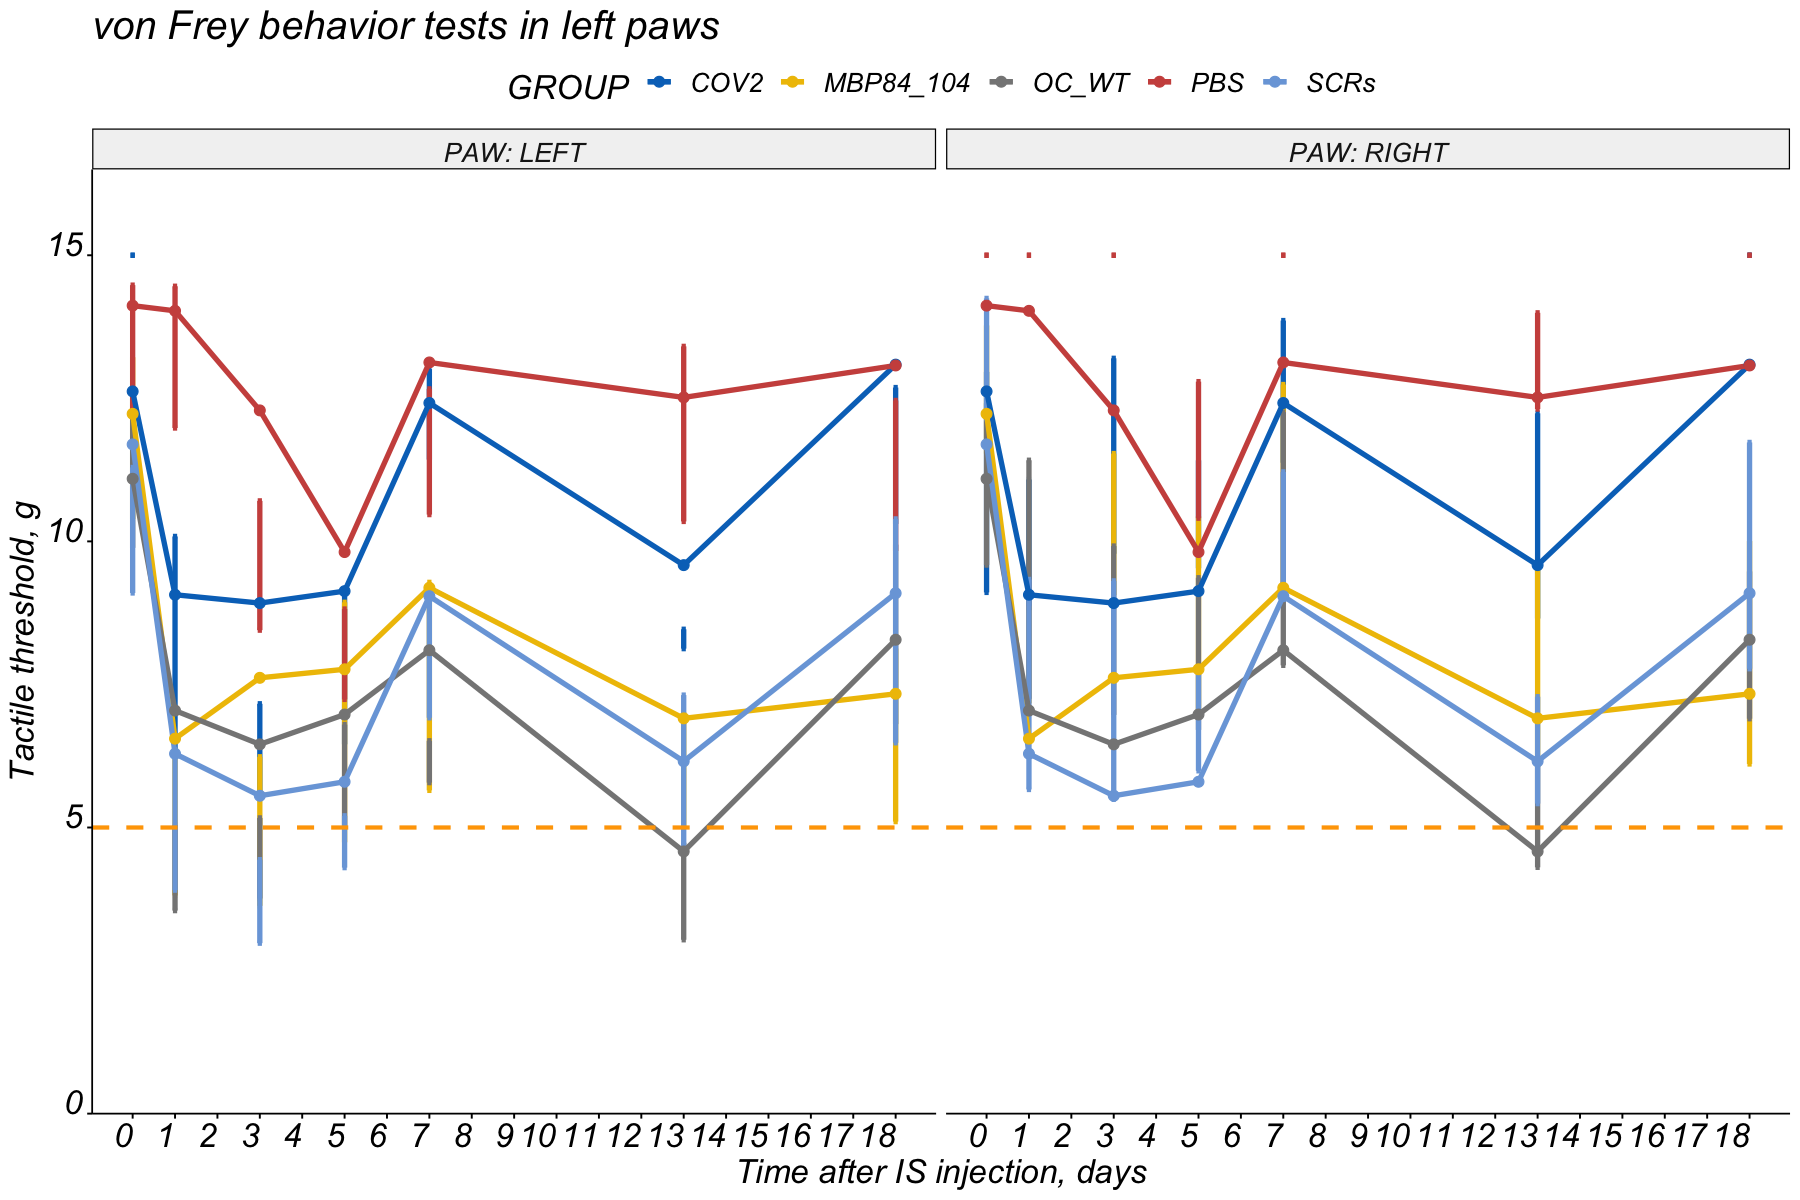

In [647]:
# Visualization: box plots with p-values

acPage(w1=15, h1=10)

x_max <- max(lp$TIMEPOINT) + 1
days <- order(unique(lp$TIMEPOINT), decreasing=F)

p <- ggline(lp, 
            x = "TIMEPOINT",
            y = "RESULT", 
            size = 1.5,            
            color = "GROUP",
            linetype = "solid",
            ylim = c(0, max_res),
            add = c("mean_se" ),
            add.params = list(width = 0.1, shape = 15),
            palette = "jco"
            )  +
    xlab("Time after IS injection, days") +
    ylab("Tactile threshold, g") +
    ggtitle( sprintf( "von Frey behavior tests in %s paws", tolower (paw))) +
    theme(text = element_text(size=20, color = "black", angle = 0, hjust = .5, vjust = 0, face = "italic"),
    axis.text.x = element_text(hjust=1)) +
    geom_hline(yintercept=5, linetype="dashed", color = "orange", size=1.2) +
    scale_y_continuous(breaks= 0 : round(max_res) * max_res/3, expand = expansion(mult = c(0, 0.1))  ) +
    scale_x_continuous(breaks= 0 : x_max * 1) + facet_wrap( ~ PAW,  labeller = "label_both")
plot(p)

In [551]:
### Plot this graph into a PDF file

In [552]:
pdf(sprintf("vonFrey plot.pdf"), width = 20, height = 20)
plot(p)
dev.off()

pdf 
  2

In [481]:
lp %>% head
meta

SEX,GROUP,PAW,TIMEPOINT,RESULT,ANIMAL_ID,DAY,ID
<chr>,<fct>,<chr>,<int>,<dbl>,<chr>,<dbl>,<int>
FEMALE,SCRs,LEFT,0,8.34,AC225,0,1
FEMALE,SCRs,LEFT,0,15.00,AC226,0,2
FEMALE,SCRs,LEFT,0,11.66,AC227,0,3
FEMALE,SCRs,LEFT,0,8.34,AC340,0,4
FEMALE,SCRs,LEFT,0,8.34,AC341,0,5
FEMALE,SCRs,LEFT,0,9.49,AC342,0,6


COMPARISON,TREATMENT,REFERENCE,SPECIES,SEX
<chr>,<chr>,<chr>,<chr>,<chr>
MBP84_104-PBS,MBP84_104,PBS,RAT,FEMALE
MBP84_104-SCRs,MBP84_104,SCRs,RAT,FEMALE
OC_WT-PBS,OC_WT,PBS,RAT,FEMALE
OC_WT-SCRs,OC_WT,SCRs,RAT,FEMALE


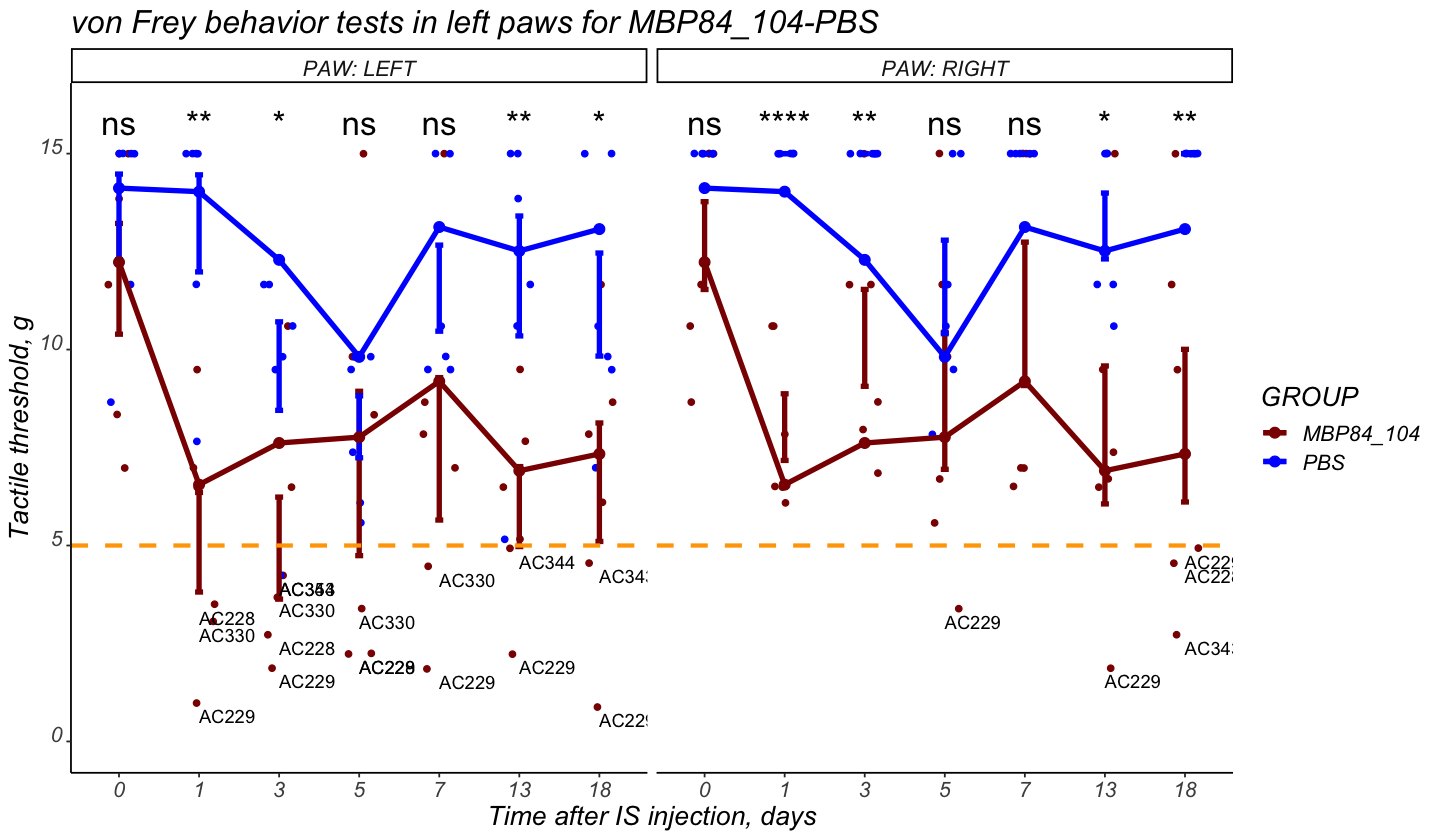

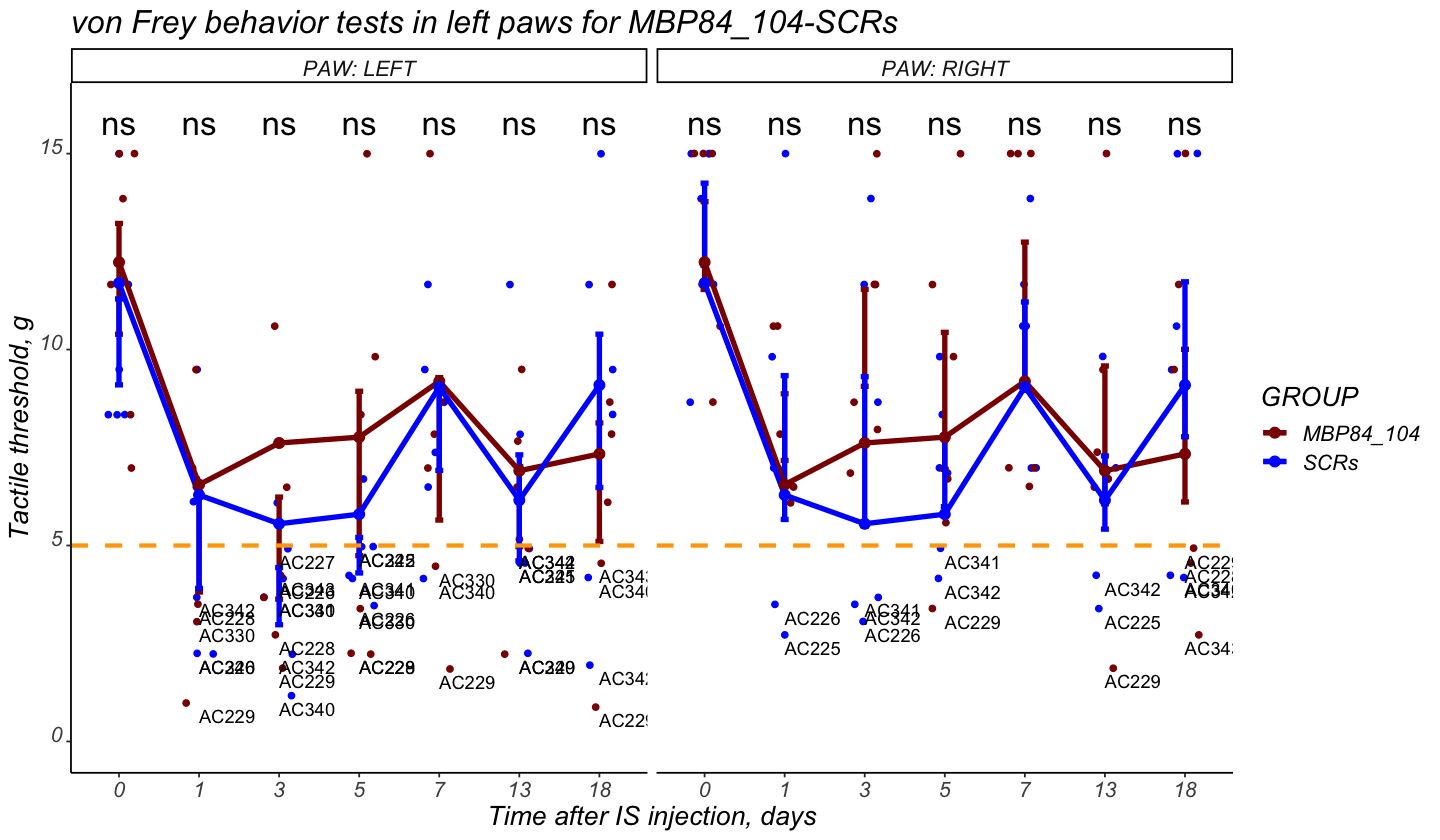

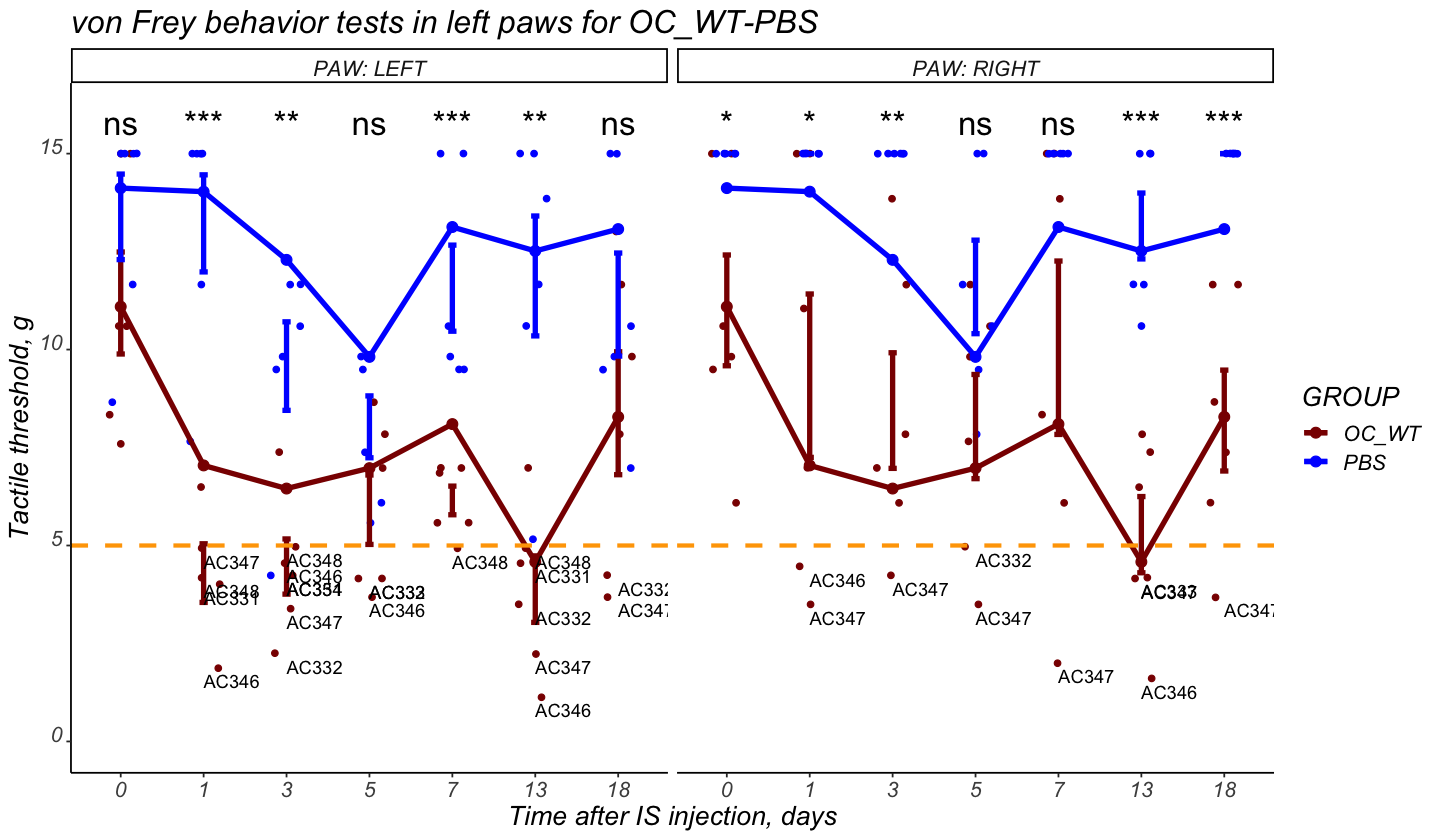

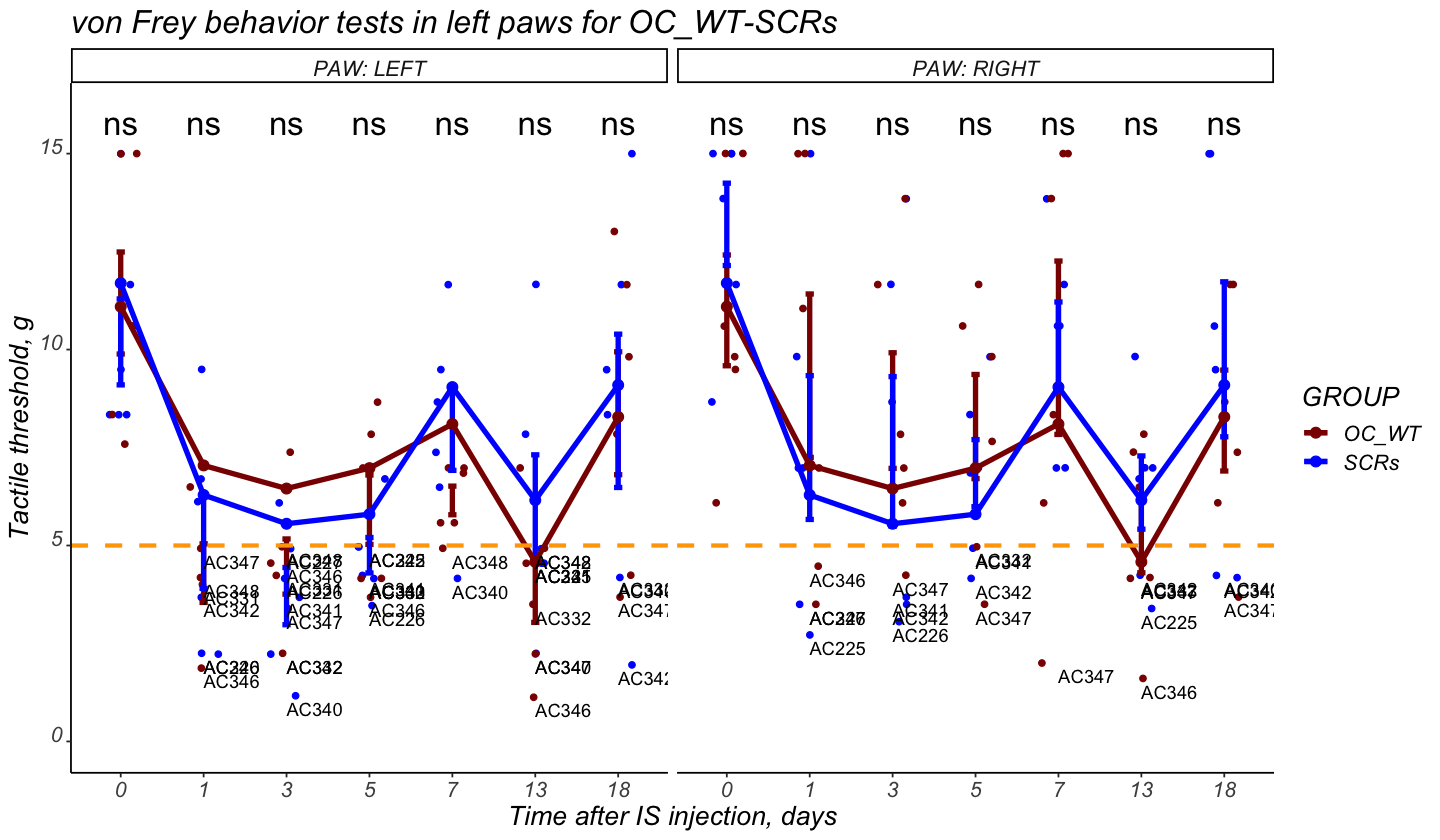

In [648]:
acPage(w1=12, h1=7)
for (i in 1:nrow(meta)){
lp1 <- lp %>% filter ( GROUP == meta$TREATMENT[i] | GROUP == meta$REFERENCE[i] ) #%>% mutate(DAY = strtoi(TIMEPOINT))
    
#pwc.f <- pwc %>% filter(group1 == meta$TREATMENT[i] & group2 == meta$REFERENCE[i])
    
pp <- ggline(lp1, y = "RESULT", x = "DAY", color = "GROUP", 
            ylim = c(0, max_res + 1),
            #xlim = c(0, 20),
            size = 1.5, binwidth=0.1, 
            add = c("mean_se" ,"jitter"),
            palette = c("darkred", "blue")
            ) +    # scale_x_continuous(breaks = 0:21*1) +
    stat_compare_means(method = "anova", aes(group = GROUP), 
                       label = "p.signif", label.y = 15.5, size=7) +
    xlab("Time after IS injection, days") +
    ylab("Tactile threshold, g") +
    ggtitle( sprintf( "von Frey behavior tests in %s paws for %s", tolower (paw), meta$COMPARISON[i])) +
    theme_classic() +
    geom_hline(yintercept=pain_threshold, linetype="dashed", color = "orange", size=1.2) +
    theme(text = element_text(size=16, color = "black", angle = 0, hjust = .5, vjust = 0, face = "italic")) +
    geom_text(aes(label=ifelse(RESULT<=pain_threshold,as.character(ANIMAL_ID),'')),hjust = 0, vjust = 1.5) +
    facet_wrap( ~ PAW,  labeller = "label_both")
plot(pp)
}

In [483]:
for (i in 1:nrow(meta)){
sprintf("Significance scores for %s vs %s, post-hoc %s", meta$TREATMENT[i], meta$REFERENCE[i], post_hoc_method) %>% print
pwc %>% filter(group1 == meta$TREATMENT[i] & group2 == meta$REFERENCE[i]) %>% 
    mutate (TIMEPOINT = as.integer(TIMEPOINT)) %>% 
    arrange (TIMEPOINT) %>% 
    select (TIMEPOINT, group1, group2, p, p.adj, p.adj.signif) %>%
    print
}

[1] "Significance scores for MBP84_104 vs PBS, post-hoc bonferroni"
# A tibble: 1 × 6
  TIMEPOINT group1    group2           p       p.adj p.adj.signif
      <int> <chr>     <chr>        <dbl>       <dbl> <chr>       
1         6 MBP84_104 PBS    0.000000156 0.000000624 ****        
[1] "Significance scores for MBP84_104 vs SCRs, post-hoc bonferroni"
# A tibble: 1 × 6
  TIMEPOINT group1    group2     p p.adj p.adj.signif
      <int> <chr>     <chr>  <dbl> <dbl> <chr>       
1         6 MBP84_104 SCRs   0.635     1 ns          
[1] "Significance scores for OC_WT vs PBS, post-hoc bonferroni"
# A tibble: 1 × 6
  TIMEPOINT group1 group2             p        p.adj p.adj.signif
      <int> <chr>  <chr>          <dbl>        <dbl> <chr>       
1         6 OC_WT  PBS    0.00000000441 0.0000000177 ****        
[1] "Significance scores for OC_WT vs SCRs, post-hoc bonferroni"
# A tibble: 1 × 6
  TIMEPOINT group1 group2     p p.adj p.adj.signif
      <int> <chr>  <chr>  <dbl> <dbl> <chr>       
1 

[1]  0  0  0  0  1  1  1  1  3  3  3  3  5  5  5  5  7  7  7  7 13 13 13 13 18
[26] 18 18 18

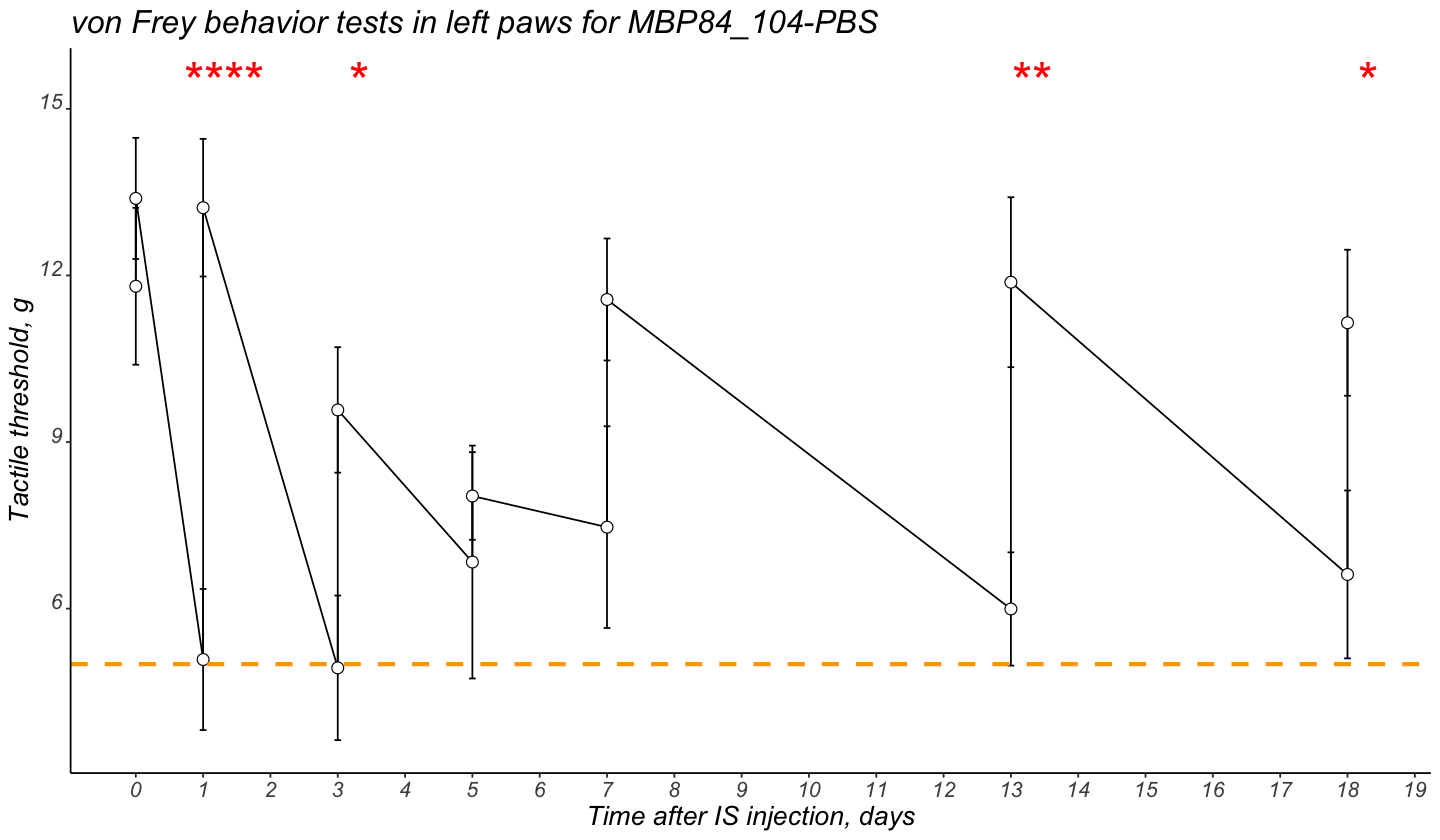

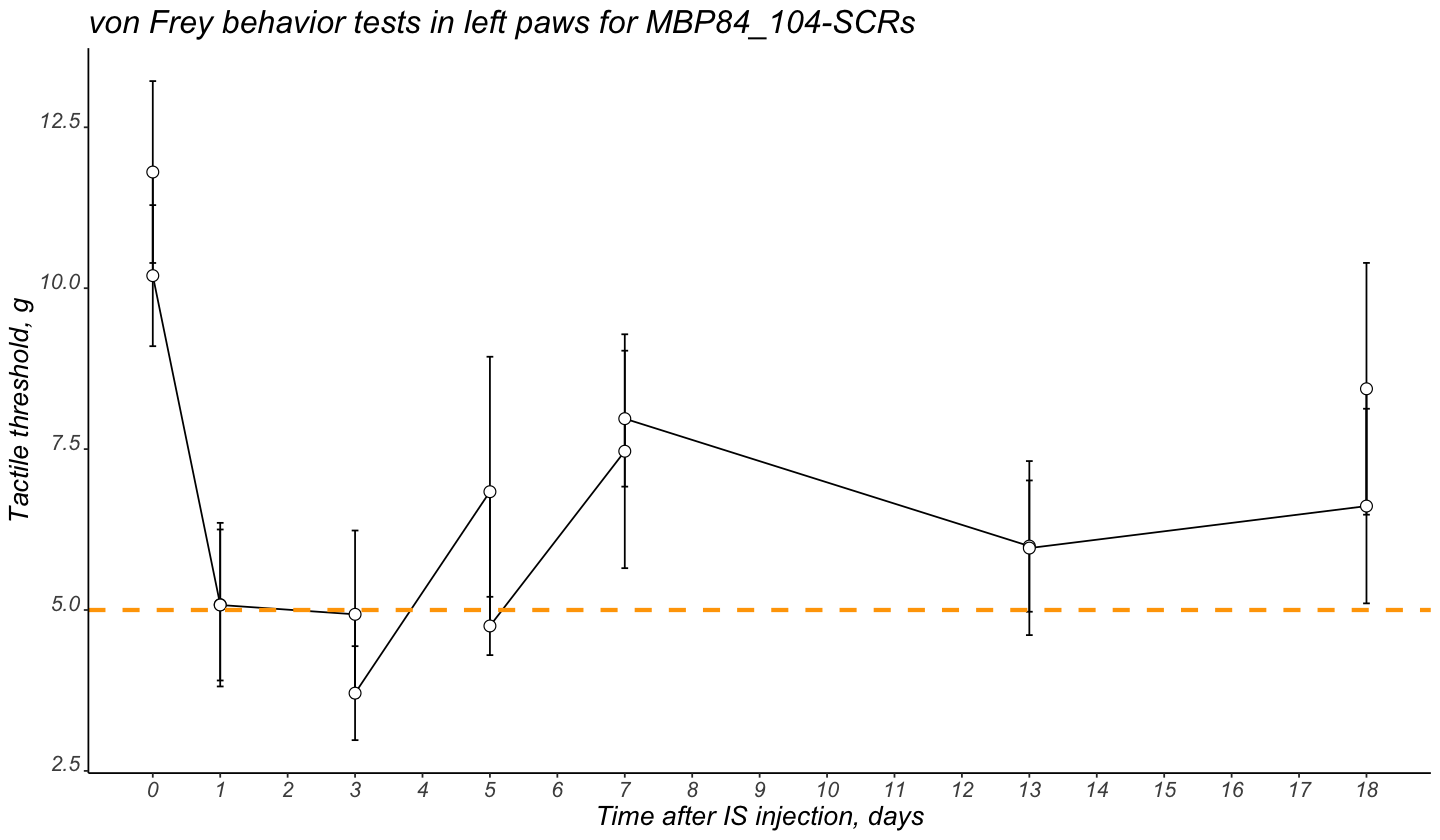

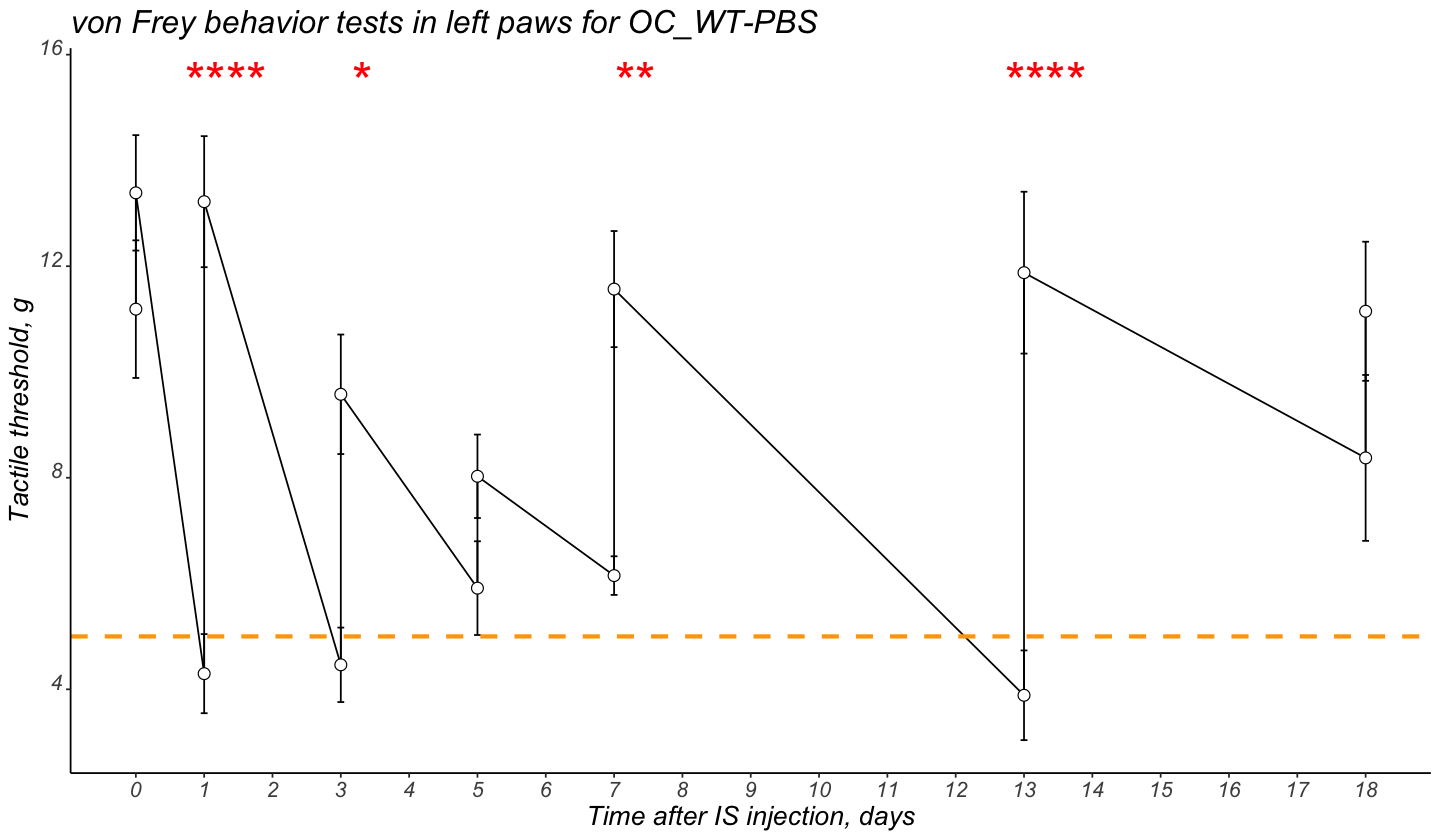

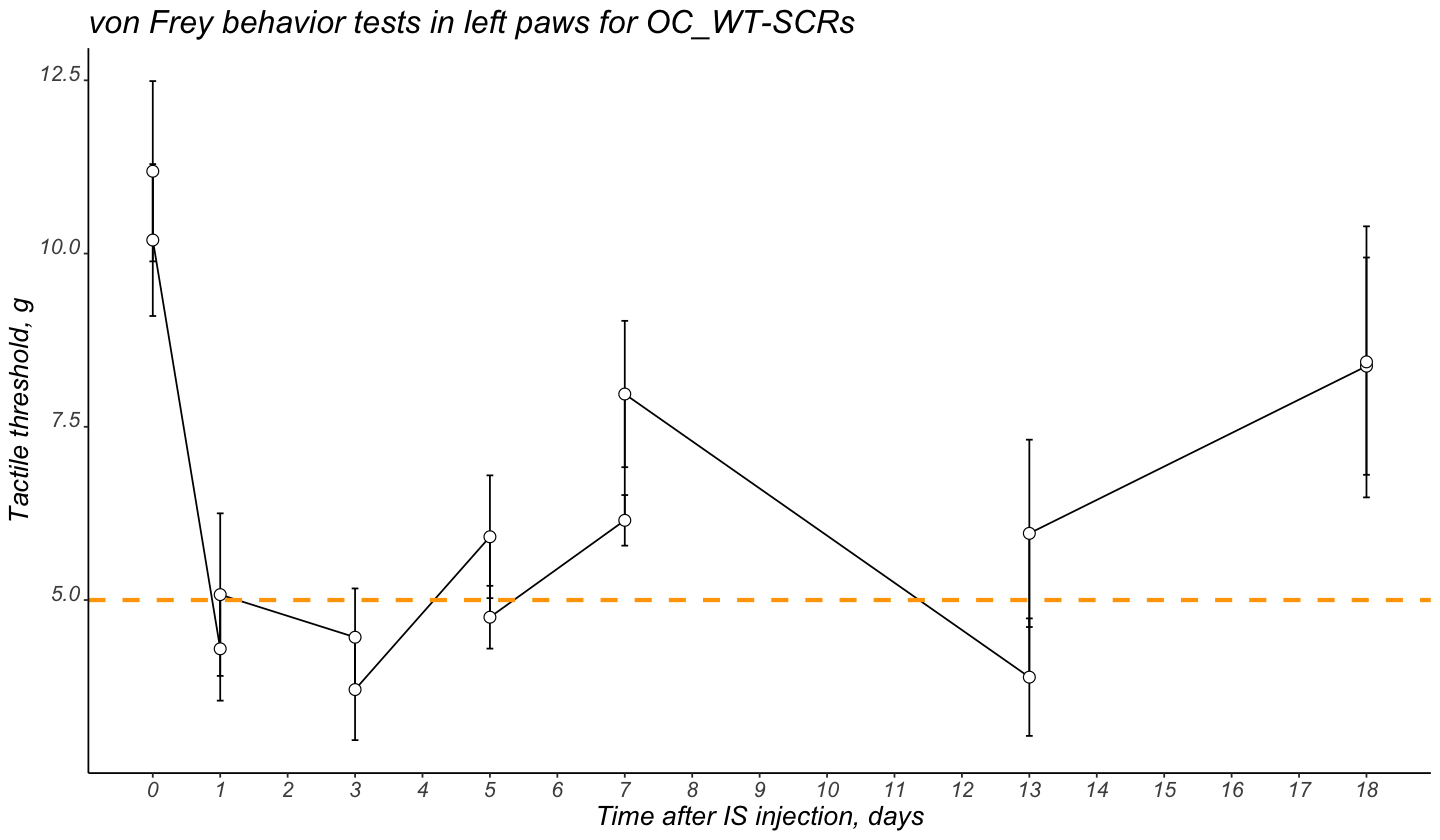

In [185]:
acPage(w1=12, h1=7)

pwc$x

for (i in 1:nrow(meta)){
lp1 <- lp_stat %>% filter ( GROUP == meta$TREATMENT[i] | GROUP == meta$REFERENCE[i] )
    
pwc.f <- pwc %>% filter(group1 == meta$TREATMENT[i] & group2 == meta$REFERENCE[i])
pd <- position_dodge(0.1) 
    
pp <- ggplot(lp1, aes(y = mean, x = TIMEPOINT) ) + #, group = GROUP, color = GROUP, shape = GROUP, linetype = GROUP)) +
    geom_errorbar(aes(ymin=mean-se, ymax=mean+se), colour="black", width=.1, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd, size=3, shape=21, fill="white") + # 21 is filled circle
        scale_x_continuous(breaks = 0:21*1) +
        stat_pvalue_manual( pwc.f, 
                            label = "p.adj.signif",
                            position = "identity",
                            remove.bracket = T,
                            size = 11,
                            y.position = 15.5,
                            hide.ns = T,
                            color = "red"
                            ) +
    xlab(label = "Time after IS injection, days") +
    ylab(label = "Tactile threshold, g") +
    ggtitle( sprintf( "von Frey behavior tests in %s paws for %s", tolower (paw), meta$COMPARISON[i])) +
    theme_classic() +
    #geom_point(shape = c(13,15), size = 3)+
    geom_hline(yintercept=pain_threshold, linetype="dashed", color = "orange", size=1.2) +
    theme(text = element_text(size=16, color = "black", angle = 0, hjust = .5, vjust = 0, face = "italic")) #+
   # geom_text(aes(label=ifelse(mean<=pain_threshold,as.character(ANIMAL_ID),'')),hjust = 0, vjust = 1.5) #+
plot(pp)
}